In [1]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import hyperdual
import motor_jacobian
from versor.drawing import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
rotor = (vsr.Biv(1,0,0).unit() * pi/6).exp()

In [3]:
n_points=10
sigma = 0.01
vectors_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).unit() for i in range(n_points)]
vectors_b = [vector.spin(rotor) for vector in vectors_a]
vectors_b_noisy = [vsr.Vec(*(np.array(vector)
                            + sigma * np.random.randn(3))).null() 
                  for vector in vectors_b]

In [4]:
vectors_a = [vsr.Vec(1,0,0), vsr.Vec(0,1,0), vsr.Vec(0,0,1)]
vectors_b = [a.spin(rotor) for a in vectors_a]

In [5]:
ans = [hyperdual.hyperdualB(a,b,vsr.Biv(0,pi/6,0).exp()) for a,b in zip(vectors_a, vectors_b)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)[1:]
Hess = np.sum([t[2] for t in ans], axis=0)

In [6]:
grad

array([ 2.5981, -2.5981, -1.5   ])

In [7]:
ans

[(0.7499999999999999,
  array([ 0.   ,  0.866, -0.866, -1.5  ]),
  array([[ 2.5  ,  1.5  , -0.866],
         [ 1.5  ,  2.5  ,  0.866],
         [-0.866,  0.866,  1.5  ]])),
 (0.49999999999999983,
  array([ 0.    ,  1.7321,  0.    ,  0.    ]),
  array([[ 3.    ,  0.    ,  0.    ],
         [ 0.    ,  1.    , -1.7321],
         [ 0.    , -1.7321,  3.    ]])),
 (0.49999999999999983,
  array([ 0.    ,  0.    , -1.7321,  0.    ]),
  array([[ 1.    ,  0.    ,  1.7321],
         [ 0.    ,  3.    ,  0.    ],
         [ 1.7321,  0.    ,  3.    ]]))]

In [8]:
print(Hess)

[[ 6.5    1.5    0.866]
 [ 1.5    6.5   -0.866]
 [ 0.866 -0.866  7.5  ]]


In [9]:
aegas = [vsr.EGA(a) for a in vectors_a]
begas = [vsr.EGA(b) for b in vectors_b]
aegas

[EGA: [ 0 1 0 0 0 0 0 0 ], EGA: [ 0 0 1 0 0 0 0 0 ], EGA: [ 0 0 0 1 0 0 0 0 ]]

In [10]:
begas

[EGA: [ 0 0.5 0.87 0 0 0 0 0 ],
 EGA: [ 0 -0.87 0.5 0 0 0 0 0 ],
 EGA: [ 0 0 0 1 0 0 0 0 ]]

In [417]:
a = aegas[0]
b = begas[0]

In [418]:
R = vsr.EGA(vsr.Biv(0,pi/6,0).exp())
R

EGA: [ 0.87 0 0 0 0 -0.5 0 0 ]

In [419]:
B = vsr.EGA(vsr.Biv(1,0,0))
gr = vsr.EGA(vsr.Biv(*ans[0][1][1:]))
gr
rar = a.spin(R)

In [420]:
B * a.spin(R) * b - a.spin(R) * B * b

EGA: [ -0.87 0 0 0 0.5 0 0 0 ]

In [421]:
B * a.spin(R) * b - b * a.spin(R) * B

EGA: [ -0.87 0 0 0 0 0 0 0 ]

In [422]:
B * a.spin(R) * b + B * a.spin(R) * b

EGA: [ -0.87 0 0 0 0.5 -1.5 0.87 0 ]

In [423]:
(B * 2) * a.spin(R) * b

EGA: [ -0.87 0 0 0 0.5 -1.5 0.87 0 ]

In [424]:
2 * a.spin(R) ^ b

EGA: [ 0 0 0 0 0.87 -0.87 -1.5 0 ]

In [425]:
a.spin(R) * b - b * a.spin(R)

EGA: [ 0 0 0 0 0.87 -0.87 -1.5 0 ]

In [426]:
gr <= B

EGA: [ -0.87 0 0 0 0 0 0 0 ]

In [427]:
B = vsr.EGA(vsr.Biv(1,0,0))
2 * rar * B.rev() * b

EGA: [ -0.87 0 0 0 0.5 1.5 -0.87 0 ]

In [428]:
B 

EGA: [ 0 0 0 0 1 0 0 0 ]

In [430]:
(2 * rar * B.rev() * b) <= vsr.EGA(vsr.Biv(0,1,0))

EGA: [ -1.5 0 0 0 0 -0.87 0 0 ]

In [408]:
def Hij(Bi,Bj,a,b,rot): 
#     print(((Bi * Bj + Bj * Bi) * a.spin(rot) * b)[0] )
#     print(((a.spin(rot) * (Bi.rev() * Bj.rev() + Bj.rev() * Bi.rev()) * b)[0]))
#     print((2 * Bi * a.spin(rot) * Bj.rev() * b)[0])
    ans = (
#         ((Bi * Bj + Bj * Bi) * a.spin(rot) + a.spin(rot) * (Bi.rev() * Bj.rev() + Bj.rev() * Bi.rev())) * b * 4
#         +
         (4 * Bi * a.spin(rot) * Bj.rev() ) * b
        ) * -0.5
#     print(ans)
    return ans[0] 

In [409]:
def Hess2(a,b,rot):
    a = vsr.EGA(a)
    b = vsr.EGA(b)
    R = vsr.EGA(rot)
    E12 = vsr.EGA(vsr.Biv(1,0,0))
    E13 = vsr.EGA(vsr.Biv(0,1,0))
    E23 = vsr.EGA(vsr.Biv(0,0,1))
    return np.array([[Hij(E12,E12,a,b,R), Hij(E12,E13,a,b,R),Hij(E12,E23,a,b,R)],
                     [Hij(E13,E12,a,b,R), Hij(E13,E13,a,b,R),Hij(E13,E23,a,b,R)],
                     [Hij(E23,E12,a,b,R), Hij(E23,E13,a,b,R),Hij(E23,E23,a,b,R)]])

In [410]:
def grad2(a,b,rot):
    def grad_ij(B, a ,b,rot):
        return (B.comm(a.spin(rot)) * b * -2)[0]
    return vsr.Biv(grad_ij(vsr.Biv(1,0,0),a,b,rot),
                   grad_ij(vsr.Biv(0,1,0),a,b,rot),
                   grad_ij(vsr.Biv(0,0,1),a,b,rot))

In [411]:
a = vsr.Vec(1,0,0)
b = a.spin((vsr.Biv(1,0,0).unit() * pi/6).exp())
R = (vsr.Biv(0,1,1).unit() * pi/6).exp()

In [414]:
a = vsr.Vec(1,0,0)
b = a.spin((vsr.Biv(1,0,0).unit() * pi/6).exp())

# print((a * a)[0])
R = (vsr.Biv(0,1,0).unit() * pi/6).exp()

# R = rotor
print(Hess2(a,b,R),'\n')
print(hyperdual.hyperdualB(a,b,R)[2])

[[ 0.5    1.5   -0.866]
 [ 1.5    0.5    0.866]
 [-0.866  0.866 -0.5  ]] 

[[ 2.5    1.5   -0.866]
 [ 1.5    2.5    0.866]
 [-0.866  0.866  1.5  ]]


In [380]:
-26.8301270189 -16.4903810568

-43.320508075700005

In [329]:
H = ans[0][2]
np.dot(np.dot(np.array([1,0,0]).reshape(3,1).T,H),np.array([0,1,0]).reshape(3,1))

array([[ 1.5]])

In [330]:
cos(pi/6) - (pi / 9 )

0.51695955338557287

In [364]:
# R = vsr.Biv(0,pi/4,0).exp()
(Hess2(a,b,R).copy()-hyperdual.hyperdualB(a,b,R)[2].copy() )

-26.8301270189
-26.8301270189
0.0
0.0
0.0
0.0
0.0
0.0
-26.8301270189
-26.8301270189
0.0
0.0
0.0
0.0
0.0
0.0
-26.8301270189
-26.8301270189


array([[-28.,   0.,   0.],
       [  0., -28.,   0.],
       [  0.,   0., -28.]])

In [442]:
a.spin(R) <= b

0.22331512190337027

In [443]:
2 * pi /4

1.5707963267948966

In [301]:
cos(pi / 1)

0.96592582628906831

In [287]:
print(Hess2(a,b,R).copy()[0,0])
print(hyperdual.hyperdualB(a,b,R)[2].copy()[0,0])

1.6152051258
4.64765093681


In [275]:
ans[0][2]

array([[ 3.49  , -1.2479,  1.3431],
       [-1.2479,  3.4606,  2.3204],
       [ 1.3431,  2.3204,  3.119 ]])

In [94]:
((vsr.Biv(1,2,3).unit() * pi/6).exp() * rotor).rev()

Rot: [ 0.68 0.55 0.43 0.21 ]

In [96]:
rotor.rev() * (vsr.Biv(1,2,3).unit() * pi/6).exp().rev()

Rot: [ 0.68 0.55 0.43 0.21 ]

In [72]:
E = np.array([1,0,0]).reshape(3,1)
np.dot(np.dot(E.T, H2), E)

array([[ 8.]])

In [31]:
rotor = (vsr.Biv(1,2,3).unit() * pi/6).exp()
a = vsr.Vec(1,0,0)
b = a.spin(rotor)
rotor1 = vsr.Biv(0,0,pi/6).exp()
_,_,H = hyperdual.hyperdualB(a,b,rotor1)
print(H)

[[ 3.6429  0.     -1.1401]
 [ 0.      3.6429  0.0343]
 [-1.1401  0.0343  0.3571]]


In [32]:
Hess2(vsr.EGA(a), vsr.EGA(b), vsr.EGA(rotor1))

array([[ 3.2857, -0.    , -1.1401],
       [-0.    ,  3.2857,  0.0343],
       [-1.1401,  0.0343, -0.    ]])

In [81]:
E12 * cos(pi/6)

EGA: [ 0 0 0 0 0.87 0 0 0 ]

In [ ]:
Hij()

In [87]:
vectors_a = [vsr.Vec(1,0,0), vsr.Vec(0,1,0), vsr.Vec(0,0,1)]
vectors_b = [a.spin(rotor) for a in vectors_a]

In [172]:
n_points=10
vectors_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)) for i in range(n_points)]
vectors_b = [vector.spin(rotor) for vector in vectors_a]

In [173]:
rot = vsr.Rot(1,0,0,0)
np.sum([np.array(Hess2(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)

array([[ 10.3645,  -0.0743,   2.1957],
       [ -0.0743,  26.2738,   2.8273],
       [  2.1957,   2.8273,  25.0241]])

In [174]:
ans = [hyperdual.hyperdualB(a,b,rot) for a,b in zip(vectors_a, vectors_b)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)[1:]
Hess = np.sum([t[2] for t in ans], axis=0)
Hess

array([[ 15.5467,  -0.0743,   2.1957],
       [ -0.0743,  31.456 ,   2.8273],
       [  2.1957,   2.8273,  30.2063]])

In [180]:
def update(rot):
    ans = [hyperdual.hyperdualB(a,b,rot) for a,b in zip(vectors_a, vectors_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)[1:]
    Hess = np.sum([t[2] for t in ans], axis=0)
#     print(Hess)
#     Hess = -np.sum([np.array(Hess2(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)
#     print(Hess)
    B = np.dot(np.linalg.pinv(Hess),grad)
    rot = vsr.Biv(*B).exp() * rot
#     rot = vsr.Biv(*(-grad * 0.1)).exp() * rot
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [181]:
rot = vsr.Rot(1,0,0,0)
for i in range(10):
    rot, res, grad_norm = update(rot)
    print(res)
print(rot)

2.59111754256
0.0299164378443
2.7838910082e-08
2.22898228791e-26
2.34602341351e-32
2.16667118744e-33
1.87778169578e-33
1.85972610255e-33
1.84167050932e-33
1.76944813641e-33
Rot: [ 0.87 -0.5 3.1e-19 1e-17 ]


In [27]:
rot = vsr.Rot(1,0,0,0)
J = np.array([jacrot(a,rot) for a in vectors_a]).reshape(-1,3)
print(np.dot(J.T,J))

[[ 48.7058  -5.3866  -6.1855]
 [ -5.3866  61.2508  11.2363]
 [ -6.1855  11.2363  45.2607]]


In [28]:
Hess = np.sum([hyperdual.hyperdualB(a,b,rot)[2] for a,b in zip(vectors_a, vectors_b)], axis=0)
print(Hess)

[[ 36.5294  -1.3615  -6.9716]
 [ -1.3615  47.5223  12.542 ]
 [ -6.9716  12.542   58.9892]]


In [11]:
motor1 = vsr.Mot(1,0,0,0,0,0,0,0)
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
points_a = [a.null() for a in vectors_a]
points_b = [a.spin(motor) for a in points_a]
a = points_a[0]
b = points_b[0]
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]

In [12]:
motor0 = vsr.Mot(1,0,0,0,0,0,0,0)
r,g,H = hyperdual.hyperdualmotor(a,b, motor0)
# print(g)
print(H)

[[ 0.2752 -1.9813 -2.1816  0.819   2.2466  0.    ]
 [-1.9813  4.9001 -0.7541 -4.4452  0.      2.2466]
 [-2.1816 -0.7541  2.8925  0.     -4.4452 -0.819 ]
 [ 0.819  -4.4452  0.      4.      0.      0.    ]
 [ 2.2466  0.     -4.4452  0.      4.      0.    ]
 [ 0.      2.2466 -0.819   0.      0.      4.    ]]


In [16]:
ans = [hyperdual.hyperdualmotor(a,b,motor0) for a,b in zip(points_a, points_b_noisy)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)
Hess = np.sum([t[2] for t in ans], axis=0)

In [17]:
print(grad * -2) 

[-18.0536 -32.0899   5.8243 -35.3993 -40.0564 -46.677 ]


In [20]:
vsr.Dll(*grad).spin(motor0)

Dll: [ 9.027 16.04 -2.912 17.7 20.03 23.34 ]

In [41]:
print(np.array(motor0 * vsr.Dll(*(np.sum([np.array(vsr.CGA(a.spin(motor0) ^ b) * 2)[6:12]
                        for a, b in zip(points_a, points_b_noisy)], axis=0)) * 2)))

[  0.      18.0536  32.0899  -5.8243 -35.3993 -40.0564 -46.677    0.    ]


In [43]:
np.array(vsr.CGA(points_a[0].spin(motor0) ^ points_b[0] ) * 2)[6:16]

array([ 1.2437,  0.5495, -2.6613, -0.5882, -2.    , -2.1424,  0.6601,
       -2.6221,  0.254 ,  2.3017])

In [44]:
grad * 2

array([ 18.0536,  32.0899,  -5.8243,  35.3993,  40.0564,  46.677 ])

In [24]:
print(Hess)

[[ 27.2651  -4.2953  -2.1054 -10.5317  25.9077   0.    ]
 [ -4.2953  30.6402   3.1073 -24.0015   0.      25.9077]
 [ -2.1054   3.1073  14.6649   0.     -24.0015  10.5317]
 [-10.5317 -24.0015   0.      40.       0.       0.    ]
 [ 25.9077   0.     -24.0015   0.      40.       0.    ]
 [  0.      25.9077  10.5317   0.       0.      40.    ]]


In [25]:
motor.dll()

Dll: [ 0 -0.5 0 -0.683 -0.433 -0.183 ]

In [39]:
scene = Scene(children=
              [point_mesh(point,color=Colors.HOTPINK) for point in points_a] +\
              [point_mesh(point,color=Colors.LIGHTSKYBLUE) for point in points_b] +\
              [line_mesh(vsr.Dll(*grad ))] +\
              [line_mesh(motor.dll())] +\
#               [point_mesh(point,color='palegreen') for point in points_b_noisy] +\
#               [point_mesh(point.spin(motors[1]),color='palegreen') for point in points_a] +\
#               [point_mesh(point.spin(em_point_3_res_noise),color=Colors.HOTPINK) for point in points_a] +\
#             [point_mesh(point.spin(vd_em_points_noise),color=Colors.BLACK) for point in points_a] +\

              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
# renderer.width = '1024'
# renderer.height = '768'
display(renderer)

In [40]:
def update(rot):
    ans = [hyperdual.hyperdualmotor(a,b,rot) for a,b in zip(points_a, points_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)
    Hess = np.sum([t[2] for t in ans], axis=0)
    B = -np.dot(np.linalg.pinv(Hess),grad)
    rot = vsr.Dll(*B).exp() * rot
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [41]:
M = motor + vsr.Mot(0,2,0,0,0,0,0,0)
M * M.rev()

Mot: [ 5 0 0 0 8.3e-17 -2.8e-17 5.6e-17 0.73 ]

In [42]:
M2 = M.retract()
M2 * M2.rev()

Mot: [ 1 0 0 0 -1.1e-17 -1.4e-17 0 -2.8e-17 ]

In [43]:
def update2(rot):
    ans = [hyperdual.hyperdualmotor(a,b,rot) for a,b in zip(points_a, points_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)
    Hess = np.sum([t[2] for t in ans], axis=0)
    B = np.dot(np.linalg.pinv(Hess),grad)
    B = vsr.Mot(0,B[0], B[1], B[2], B[3], B[4], B[5], 0)
    rot = (rot * B ).retract()
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [44]:
rot = vsr.Mot(1,0,0,0,0,0,0,0)
res = 1e6
i = 0
# while res > 1e-6:
for i in range(10):
    i += 1
    rot, res, grad_norm = update(rot)
    print(res)
    print(rot)
# print(i)

24.6664441627
Mot: [ 0.39 -0.28 -0.87 -0.12 -0.91 -0.21 0.054 -0.23 ]
14.4489321359
Mot: [ 0.82 -0.068 -0.57 -0.0082 -0.69 -0.37 -0.11 -0.24 ]
0.33608605296
Mot: [ 0.87 0.0037 -0.5 -0.00019 -0.68 -0.44 -0.18 -0.25 ]
0.000615678852544
Mot: [ 0.87 7.6e-07 -0.5 -1.3e-07 -0.68 -0.43 -0.18 -0.25 ]
2.01033878997e-11
Mot: [ 0.87 7.6e-07 -0.5 -1.3e-07 -0.68 -0.43 -0.18 -0.25 ]
6.03335974378e-11
Mot: [ 0.87 7.6e-07 -0.5 -1.3e-07 -0.68 -0.43 -0.18 -0.25 ]
6.03335973657e-11
Mot: [ 0.87 7.6e-07 -0.5 -1.3e-07 -0.68 -0.43 -0.18 -0.25 ]
6.03335973657e-11
Mot: [ 0.87 7.6e-07 -0.5 -1.3e-07 -0.68 -0.43 -0.18 -0.25 ]
6.03335973657e-11
Mot: [ 0.87 7.6e-07 -0.5 -1.3e-07 -0.68 -0.43 -0.18 -0.25 ]
6.03335973657e-11
Mot: [ 0.87 7.6e-07 -0.5 -1.3e-07 -0.68 -0.43 -0.18 -0.25 ]


In [45]:
np.linalg.norm(rot.rev() * motor)

1.0000000000011913

In [46]:
print(rot.rev() * motor)

Mot: [ 1 -7.2e-07 -5e-07 -2.7e-07 5.4e-07 -1.1e-06 -9.6e-07 -2.8e-17 ]


In [47]:
import motor_jacobian

In [48]:
def jacmot(a,mot):
    j = np.zeros((3,6))
    for i in range(6):
        dll = vsr.Dll(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        dll[i] = 1.0
        j[:,i] = 2. * np.array(dll.comm(a.spin(mot)))[:3]
    return j

In [49]:
J = np.array([jacmot(a,motor0) for a in points_a]).reshape(-1,6)

In [50]:
np.dot(J.T,J)

array([[ 48.7058,  -5.3866,  -6.1855,  -5.8172,  -9.2889,   0.    ],
       [ -5.3866,  61.2508,  11.2363,   8.3749,   0.    ,  -9.2889],
       [ -6.1855,  11.2363,  45.2607,   0.    ,   8.3749,   5.8172],
       [ -5.8172,   8.3749,   0.    ,  40.    ,   0.    ,   0.    ],
       [ -9.2889,   0.    ,   8.3749,   0.    ,  40.    ,   0.    ],
       [  0.    ,  -9.2889,   5.8172,   0.    ,   0.    ,  40.    ]])

In [51]:
n_points = 10
sigma = 0.09
points_a = [(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

In [52]:
def jac(a, mot):
    j = np.zeros((6,6))
    for i in range(6):
        ei = vsr.Dll(0.0, 0.0, 0.0,0.0,0.0,0.0)
        ei[i] = 1.0
        j[:,i] = 2.0 * np.array(ei.comm(a.spin(mot))) # Wrong sign?
    return j

In [53]:
J = np.array([jac(a, motor0) for a in lines_a]).reshape(-1,6)

In [54]:
np.dot(J.T,J)

array([[ 58.6305,  -8.3942,  -4.9776,   3.0429,  -8.5226,   0.8184],
       [ -8.3942,  47.1602,   2.538 ,   5.9672,   0.5802,   1.7896],
       [ -4.9776,   2.538 ,  69.5554,  -0.2382,  11.1114,  -1.7241],
       [  3.0429,   5.9672,  -0.2382,  27.5843,  -3.44  ,   1.0583],
       [ -8.5226,   0.5802,  11.1114,  -3.44  ,  23.873 ,   0.7635],
       [  0.8184,   1.7896,  -1.7241,   1.0583,   0.7635,  28.5428]])

In [55]:
f = np.array([np.array(a.spin(motor0) - b) for a,b in zip(lines_a, lines_b)]).reshape(-1,1)

In [56]:
vsr.Dll(*np.dot(J.T,f))

Dll: [ 2.005 22.38 9.712 16.64 6.073 7.482 ]

In [57]:
motor.dll()

Dll: [ 0 -0.5 0 -0.683 -0.433 -0.183 ]

In [80]:
np.sum([np.array(a.spin(motor0).comm(b)) for a,b in zip(lines_a, lines_b)],axis=0)

array([-1.0996, -5.1412,  0.6974, -7.6073, -1.8703, -3.3325])

In [59]:
lines_a[0].spin(motor).rev()

Dll: [ -0.09546 0.1199 0.9882 -0.07985 -0.06164 -0.7493 ]

In [60]:
lines_a[0].rev().spin(motor)

Dll: [ -0.09546 0.1199 0.9882 -0.07985 -0.06164 -0.7493 ]

In [61]:
l = lines_a[0].spin(motor0) - lines_b[0]
np.inner(l,l)

3.3127106005686877

In [62]:
np.sum([a*a for a in np.array(l)])

3.3127106005686877

In [63]:
l * l.rev()

Mot: [ 0.99 0 0 0 -1.4e-17 0 0 2 ]

In [64]:
(l.biv() * l.biv().rev() )[0] + (l.drv().vec() * l.drv().vec().rev())[0]

3.3127106005686873

In [65]:
Ba = lines_a[0]
Ba[3] = Ba[4] = Ba[5] = 0 
Ba

Dll: [ 0.9035 -0.1199 -0.4114 0 0 0 ]

In [66]:
da = lines_a[0]
da[0] = da[1] = da[2] = 0
da

Dll: [ 0 0 0 0 0 0 ]

In [67]:
Ba.spin(motor)

Dll: [ 0 0 0 0 0 0 ]

In [68]:
from hyperdual_lines import lines

In [69]:
lc = np.array(lines_a[0].spin(motor0) - lines_b[0])

In [70]:
lc[0] * lc[0]

0.0091126709011720292

In [82]:
lines(lines_a[0], lines_b[0], motor0)

(2.3438572467752534,
 array([ 0.6305,  1.5194,  0.839 ,  3.1588,  1.221 ,  1.2234]),
 array([[ 6.3037,  2.3807, -0.128 ,  1.7385, -3.1509, -1.4473],
        [ 2.3807,  1.7281, -1.868 ,  0.6658, -1.8632,  0.3992],
        [-0.128 , -1.868 ,  2.1448,  1.4388,  1.217 ,  1.4332],
        [ 1.7385,  0.6658,  1.4388,  3.0793,  1.2342,  1.1454],
        [-3.1509, -1.8632,  1.217 ,  1.2342,  2.3456, -1.5354],
        [-1.4473,  0.3992,  1.4332,  1.1454, -1.5354,  2.5751]]))

In [144]:
ans = [lines(a,b,motor0) for a,b in zip(lines_a, lines_b)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)
Hess = np.sum([t[2] for t in ans], axis=0)
print(grad)

[ -1.6227  18.1036   0.5045  16.1447   3.488    6.0326]


In [136]:
vsr.Dll(*grad).spin(motor0)

Dll: [ -0.0001897 0.0009591 -0.0003227 -7.821e-05 -5.202e-05 0.0001677 ]

In [140]:
(motor0 * vsr.Dll(*np.sum([np.array(a.spin(motor0).comm(b)) 
                          for a,b in zip(lines_a, lines_b)],axis=0))).dll()

Dll: [ -1.1 -5.141 0.6974 -7.607 -1.87 -3.332 ]

In [142]:
vsr.Dll(*np.sum([np.array(a.spin(motor0).comm(b)) 
                          for a,b in zip(lines_a, lines_b)],axis=0))

Dll: [ -1.1 -5.141 0.6974 -7.607 -1.87 -3.332 ]

In [73]:
n_points = 10
sigma = 0.09
points_a = [(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

In [74]:
def update(rot):
    ans = [lines(a,b,rot) for a,b in zip(lines_a, lines_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)
    Hess = np.sum([t[2] for t in ans], axis=0)
    B = -np.dot(np.linalg.pinv(Hess),grad)
    rot = vsr.Dll(*B).exp() * rot
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [146]:
rot = vsr.Mot(1,0,0,0,0,0,0,0)
res = 1e6
i = 0
ress = []
while res > 1e-3:
# for i in range(100):
    i += 1
    rot, res, grad_norm = update(rot)
    ress.append(res)
print(ress)
print(rot)
print(i)

[15.067717341654191, 70.859718634682508, 27.21047468006136, 11.362096158839881, 1.2849517612321126, 0.0026943798910338095, 1.1174104728907871e-08]
Mot: [ 0.87 1.8e-06 -0.5 -2.9e-06 -0.68 -0.43 -0.18 -0.25 ]
7


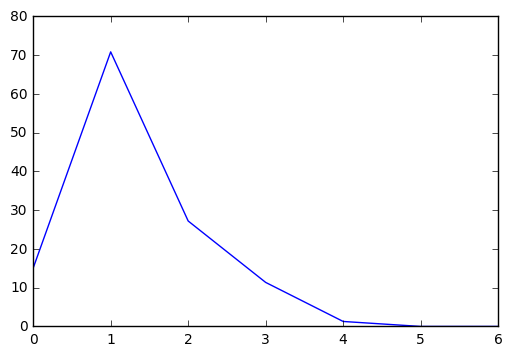

In [148]:
plot(ress);